# Topic Modelling of TensorFlow Posts

This notebook demonstrates a topic modeling process on TensorFlow-related posts from Stack Overflow using the Latent Dirichlet Allocation (LDA) algorithm. The final results include the most popular and challenging topics, providing insights into the main discussion points and difficulties faced by users in TensorFlow-related posts. The topic visualization (lda.html) helps in understanding the topic distribution and keywords associated with each topic.

## Installation of Required Libraries

In [1]:
# pip install contractions

In [15]:
# !pip install pandas
# !pip install mysql.connector-python
# !pip install contractions
# !pip install gensim==3.8.0
# ! pip install --upgrade gensim

     ---------------------------------------- 0.0/23.9 MB ? eta -:--:--
      --------------------------------------- 0.4/23.9 MB 7.4 MB/s eta 0:00:04
     - -------------------------------------- 0.8/23.9 MB 8.4 MB/s eta 0:00:03
     -- ------------------------------------- 1.3/23.9 MB 9.4 MB/s eta 0:00:03
     --- ------------------------------------ 1.9/23.9 MB 10.0 MB/s eta 0:00:03
     ---- ----------------------------------- 2.4/23.9 MB 10.3 MB/s eta 0:00:03
     ---- ----------------------------------- 3.0/23.9 MB 10.5 MB/s eta 0:00:02
     ----- ---------------------------------- 3.4/23.9 MB 10.8 MB/s eta 0:00:02
     ------ --------------------------------- 4.1/23.9 MB 11.3 MB/s eta 0:00:02
     ------- -------------------------------- 4.6/23.9 MB 11.3 MB/s eta 0:00:02
     -------- ------------------------------- 5.2/23.9 MB 11.4 MB/s eta 0:00:02
     --------- ------------------------------ 5.7/23.9 MB 11.4 MB/s eta 0:00:02
     ---------- ----------------------------- 6.2/2

## Imports


In [1]:
#Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from mysql.connector import Error
pd.set_option('display.max_colwidth', 200)

## Database Connection Functions


In [2]:
#DB Connection functions
def create_db_connection(host_name, user_name, user_password, db_name):
    connection = None
    try:
        connection = mysql.connector.connect(
            host=host_name,
            user=user_name,
            passwd=user_password,
            database=db_name
        )
        print("MySQL Database connection successful")
    except Error as err:
        print(f"Error: '{err}'")

    return connection

## Establishing Database Connection and Retrieving Data


In [3]:
#DB Connection establishment
db="stackoverflow"
pw="Password"
connection = create_db_connection("localhost", "root", pw, db)

MySQL Database connection successful


In [4]:
query5_2 = """
Select Id, Body, Title
from posts_tensorflow02
WHERE YEAR(CreationDate) >= 2015
And PostTypeId = 1;
"""

In [5]:
# Execute the query and retrieve the results into a pandas DataFrame
df_subset = pd.read_sql(query5_2, connection)

C:\Users\x8i10\AppData\Local\Temp\ipykernel_14948\2017578986.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_subset = pd.read_sql(query5_2, connection)


In [6]:
# Close the database connection
connection.close()

In [7]:
df_subset

,Id,Body,Title
0,27862175,"<p>This question is perhaps aimed at the creator of <em>ReactFX</em>, but others are welcome to answer.</p>&#xA;&#xA;<p>I am currently starting to use <em>ReactFX</em> for data sharing and event h...",ReactFX Consumer listening to more than one EventStream
1,28565735,"<p>I would like to find out if there is any way of animating Text, such as changing its background colour and adding some fade transitions after a certain period of time using ReactFx. &#xA;A s...",Animating Text objects using ReactFx
2,28610085,"<p>I'm trying to implement TextFX in my project to do some UI testing. However it seems I can't get it to work properly. I've downloaded the jars from <a href=""http://search.maven.org/#search%7Cga...",@Test Annotiation not working with TestFX
3,28659716,"<p>I'm working with <a href=""https://github.com/TomasMikula/RichTextFX"">RichTextFx</a>'s CodeArea to highlight custom mini language code. </p>&#xA;&#xA;<p>Now while executing this code I want to ...",Show breakpoint at line number in RichTextFx CodeArea
4,28679310,<p>I have a complex chart (jChartFx) created using javascript inside a webview on Android. I need to be able to export this chart to a png file. </p>&#xA;&#xA;<p>I've tried using html2canvas but t...,Get absolute screen coordinates of a div inside a webview on Android
...,...,...,...
105430,76397012,"<p>I've been working on a GAN for image synthesis and have been getting the same problem no matter how much I try to change my architecture/optimizers/losses, so I've gone to the mnist dataset to ...",GAN on MNIST digit dataset generating same image after one epoch and not changing after more training
105431,76397115,<p>I'm having trouble deploying the best_float16.tflite model to Kotlin because it has a different data type compared to the code I'm following. Here are the differences I have identified...</p>&#...,Can anyone suggest fixes for incorrect implementation of the best_float16.tflite model in Kotlin?
105432,76397466,<p>I'm learning machine learning from Google's &quot;Introduction to TensorFlow&quot; course. The course teaches how to create a separate test dataset and use the model you've created to test it's...,How do I change my machine learning code to work for one image instead of an entire dataset?
105433,76397822,"<p>I get this warning:</p>&#xA;<pre><code>============================&#xA;Hi, looks like you are running TensorFlow.js in Node.js. To speed things up dram&#xA;atically, install our node backend, ...",Tensorflow.js on node.js backend for speed increase warning deprecated?


In [9]:
print(len(df_subset))

105435


In [10]:
#Dropping columns not required as part of topic modelling
# df_subset = df_subset.drop(columns=[ 'PostTypeId', 'AcceptedAnswerId','CreationDate','Score','ViewCount','OwnerUserId','OwnerDisplayName','LastEditorUserId','LastEditDate','LastActivityDate','Tags','AnswerCount','LastEditorDisplayName','CommentCount','FavoriteCount','CommunityOwnedDate','ClosedDate','ContentLicense'], axis=1)


In [11]:
df_subset.head(5)

,Id,Body,Title
0,27862175,"<p>This question is perhaps aimed at the creator of <em>ReactFX</em>, but others are welcome to answer.</p>&#xA;&#xA;<p>I am currently starting to use <em>ReactFX</em> for data sharing and event h...",ReactFX Consumer listening to more than one EventStream
1,28565735,"<p>I would like to find out if there is any way of animating Text, such as changing its background colour and adding some fade transitions after a certain period of time using ReactFx. &#xA;A s...",Animating Text objects using ReactFx
2,28610085,"<p>I'm trying to implement TextFX in my project to do some UI testing. However it seems I can't get it to work properly. I've downloaded the jars from <a href=""http://search.maven.org/#search%7Cga...",@Test Annotiation not working with TestFX
3,28659716,"<p>I'm working with <a href=""https://github.com/TomasMikula/RichTextFX"">RichTextFx</a>'s CodeArea to highlight custom mini language code. </p>&#xA;&#xA;<p>Now while executing this code I want to ...",Show breakpoint at line number in RichTextFx CodeArea
4,28679310,<p>I have a complex chart (jChartFx) created using javascript inside a webview on Android. I need to be able to export this chart to a png file. </p>&#xA;&#xA;<p>I've tried using html2canvas but t...,Get absolute screen coordinates of a div inside a webview on Android


## Merging Title and Body for Topic Modelling Input


In [12]:
#Merging title and body for passing as topic modelling input
df_subset['text'] = df_subset['Title'].fillna('').str.strip() + ' ' + df_subset['Body'].fillna('').str.strip()
df_subset.head()

,Id,Body,Title,text
0,27862175,"<p>This question is perhaps aimed at the creator of <em>ReactFX</em>, but others are welcome to answer.</p>&#xA;&#xA;<p>I am currently starting to use <em>ReactFX</em> for data sharing and event h...",ReactFX Consumer listening to more than one EventStream,"ReactFX Consumer listening to more than one EventStream <p>This question is perhaps aimed at the creator of <em>ReactFX</em>, but others are welcome to answer.</p>&#xA;&#xA;<p>I am currently start..."
1,28565735,"<p>I would like to find out if there is any way of animating Text, such as changing its background colour and adding some fade transitions after a certain period of time using ReactFx. &#xA;A s...",Animating Text objects using ReactFx,"Animating Text objects using ReactFx <p>I would like to find out if there is any way of animating Text, such as changing its background colour and adding some fade transitions after a certain p..."
2,28610085,"<p>I'm trying to implement TextFX in my project to do some UI testing. However it seems I can't get it to work properly. I've downloaded the jars from <a href=""http://search.maven.org/#search%7Cga...",@Test Annotiation not working with TestFX,@Test Annotiation not working with TestFX <p>I'm trying to implement TextFX in my project to do some UI testing. However it seems I can't get it to work properly. I've downloaded the jars from <a ...
3,28659716,"<p>I'm working with <a href=""https://github.com/TomasMikula/RichTextFX"">RichTextFx</a>'s CodeArea to highlight custom mini language code. </p>&#xA;&#xA;<p>Now while executing this code I want to ...",Show breakpoint at line number in RichTextFx CodeArea,"Show breakpoint at line number in RichTextFx CodeArea <p>I'm working with <a href=""https://github.com/TomasMikula/RichTextFX"">RichTextFx</a>'s CodeArea to highlight custom mini language code. </p..."
4,28679310,<p>I have a complex chart (jChartFx) created using javascript inside a webview on Android. I need to be able to export this chart to a png file. </p>&#xA;&#xA;<p>I've tried using html2canvas but t...,Get absolute screen coordinates of a div inside a webview on Android,Get absolute screen coordinates of a div inside a webview on Android <p>I have a complex chart (jChartFx) created using javascript inside a webview on Android. I need to be able to export this cha...


## Checking Installed Gensim Version


In [13]:
pip show gensim

Name: gensim
Version: 4.3.0
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: C:\Users\x8i10\AppData\Local\anaconda3\envs\topic_modelling_gensim3.3.8\Lib\site-packages
Requires: Cython, FuzzyTM, numpy, scipy, smart-open
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [14]:
import sys
print(sys.version)

3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]


## Text Preprocessing Methods


In [15]:
#Methods to perform preprocessing
import string
import re
import contractions
from gensim import utils
from gensim.parsing.preprocessing import strip_tags, strip_numeric, stem_text, strip_multiple_whitespaces, STOPWORDS, preprocess_string
PUNC = re.sub('\#', '', string.punctuation)
PUNC = re.sub('\++', '', PUNC)
RE_PUNCT = re.compile(r'([%s])+' % re.escape(PUNC), re.UNICODE)
STOPWORDS_CUSTOM = STOPWORDS.union(set(['python','eg','via','ive','says','ok','problem', 'sentenc','sentence','code','contain','number','updat','update','understand','fix','possible','tell','code','usa','mexico','wed','obtain','error','user','write',
                                        'error','help','put','punctuat','element','fix','program','tri','work','fail','behaviour','tri','incorrect','wrong','limit','close','write','success','run','block','mark','place','great','project','number',
                                        'instead', 'need', 'look', 'use', 'like', 'want', 'saying', 'thanks', 'think', 'tried', 'perfectly', 'probably', 'simp', 'unfortunately', 'therefor', 'people', 'mention', 'example', 'formed', 'thanks', 'know', 
                                        'soon', 'occur', 'assuming', 'keeps', 'based', 'new', 'way', 'work', 'follow', 'complete', 'miss', 'idea', 'cause', 'give', 'happen', 'wrong', 'regard', 'concern', 'take', 'long', 'according', 'high', 'deal',
                                        'remain', 'total', 'matter', 'hope', 'appreciate', 'dont', 'hi', 'unable', 'person', 'hard', 'easier', 'sorry', 'mind', 'care', 'couldnt', 'wait', 'doesnt', 'welcome', 'wasnt', 'fresh', 'price', 'that', 'mat',
                                        'outlook', 'wanna', 'weird', 'shouldnt', 'nearest', 'friend', 'upper', 'thousand', 'okay', 'near', 'anybody', 'guy', 'suit', 'today', 'offer', 'smooth', 'fault', 'talk', 'somebody', 'office', 'exceed', 'reply', 
                                        'inside', 'facing', 'kindly', 'perfectly', 'perfectly', 'doesen', 'fact', 'surely', 'sample', 'occurs', 'assume', 'earlier', 'able', 'reached', 'happy', 'grab', 'details', 'relevant', 'additional', 'needed', 'usually',
                                        'trying', 'happening', 'fine', 'allows', 'sure', 'beginning','best','approach','appropriate','read','send','thank','writing','see','second','work','follow','valu','show','correct','specif','sell','chang','expect','suppo',
                                       'hoop','requir','creat','involv','intent','intend','comprehen','let','hire','return','get','add','familiar','freelanc','fulltim','sum','curiou','ask','better','simpl','question','store','suggest','paragraph','write','report','convert',
                                       'discount','futur']))

def remove_code_block(text):
    return(re.sub('<code>?(.*?)<\/code>', '',text,  flags=re.DOTALL))

#remove html characters
def html_using_re(text):
    return(re.sub("(\<.*?\>)","",text))
#Remove URL
def remove_URL(s):
    s = utils.to_unicode(s)
    """Remove URLs from a sample string"""
    return re.sub(r'https?://\S+', "", s)
#removing punctuation using string library
def rem_punctuation(text):
    removeStr=set(string.punctuation)
    return ''.join(char for char in text if char not in removeStr)
#Removing contarctions
def replace_contractions(s):
    s = utils.to_unicode(s)
    """Replace contractions in string of text"""
    return contractions.fix(s)
#Removing short words
def strip_short_custom(s, minsize=3):
    s = utils.to_unicode(s)
    return " ".join(e for e in s.split() if len(e) >= minsize)
#Removing stopwords
def remove_stopwords_custom(s):
    s = utils.to_unicode(s)
    return " ".join(w for w in s.split() if ( w not in STOPWORDS_CUSTOM))

CUSTOM_FILTERS = [lambda x: x.lower(), 
                  remove_code_block,
                  remove_URL,
                  html_using_re,
                  rem_punctuation,
                  replace_contractions,
                  strip_multiple_whitespaces,
                  strip_numeric, 
                  remove_stopwords_custom, 
                  strip_short_custom,
                  #stem_text, 
                  remove_stopwords_custom
                 ]

def text_preprocess(post):
    return (preprocess_string(str(post), CUSTOM_FILTERS))  

## Applying Text Preprocessing


In [16]:
#Applying text pre-processing
df_subset["text_preprocessed"] = df_subset["text"].apply(text_preprocess)

In [17]:
df_subset.head(5)

,Id,Body,Title,text,text_preprocessed
0,27862175,"<p>This question is perhaps aimed at the creator of <em>ReactFX</em>, but others are welcome to answer.</p>&#xA;&#xA;<p>I am currently starting to use <em>ReactFX</em> for data sharing and event h...",ReactFX Consumer listening to more than one EventStream,"ReactFX Consumer listening to more than one EventStream <p>This question is perhaps aimed at the creator of <em>ReactFX</em>, but others are welcome to answer.</p>&#xA;&#xA;<p>I am currently start...","[reactfx, consumer, listening, eventstream, aimed, creator, reactfx, answerxaxai, currently, starting, reactfx, data, sharing, event, handling, javafx, application, class, subscribe, listen, event..."
1,28565735,"<p>I would like to find out if there is any way of animating Text, such as changing its background colour and adding some fade transitions after a certain period of time using ReactFx. &#xA;A s...",Animating Text objects using ReactFx,"Animating Text objects using ReactFx <p>I would like to find out if there is any way of animating Text, such as changing its background colour and adding some fade transitions after a certain p...","[animating, text, objects, reactfx, animating, text, changing, background, colour, adding, fade, transitions, certain, period, time, reactfx, xaa, simple, appreciated, xathanks]"
2,28610085,"<p>I'm trying to implement TextFX in my project to do some UI testing. However it seems I can't get it to work properly. I've downloaded the jars from <a href=""http://search.maven.org/#search%7Cga...",@Test Annotiation not working with TestFX,@Test Annotiation not working with TestFX <p>I'm trying to implement TextFX in my project to do some UI testing. However it seems I can't get it to work properly. I've downloaded the jars from <a ...,"[test, annotiation, working, testfx, implement, textfx, testing, properly, downloaded, jars, folder, named, testfx, systemxaxaafterwards, created, library, netbeans, pointing, jar, files, jar, sou..."
3,28659716,"<p>I'm working with <a href=""https://github.com/TomasMikula/RichTextFX"">RichTextFx</a>'s CodeArea to highlight custom mini language code. </p>&#xA;&#xA;<p>Now while executing this code I want to ...",Show breakpoint at line number in RichTextFx CodeArea,"Show breakpoint at line number in RichTextFx CodeArea <p>I'm working with <a href=""https://github.com/TomasMikula/RichTextFX"">RichTextFx</a>'s CodeArea to highlight custom mini language code. </p...","[breakpoint, line, richtextfx, codearea, working, xaxanow, executing, small, arrow, current, executed, line, specific, line, line, labelxaxasince, github, claims, showing, line, numbers, breakpoin..."
4,28679310,<p>I have a complex chart (jChartFx) created using javascript inside a webview on Android. I need to be able to export this chart to a png file. </p>&#xA;&#xA;<p>I've tried using html2canvas but t...,Get absolute screen coordinates of a div inside a webview on Android,Get absolute screen coordinates of a div inside a webview on Android <p>I have a complex chart (jChartFx) created using javascript inside a webview on Android. I need to be able to export this cha...,"[absolute, screen, coordinates, div, webview, android, complex, chart, jchartfx, created, javascript, webview, android, export, chart, png, file, xaxaive, htmlcanvas, chart, rendered, svg, support..."


In [18]:
print(len(df_subset))

105435


## Converting Text to List


In [19]:
#Converting to list
data = df_subset.text.values.tolist()
data_words = df_subset.text_preprocessed.values.tolist()
print(len(data_words))

105435


## Building Bigram and Trigram Models


In [20]:
# Build the bigram and trigram models
import gensim
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [21]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [22]:
data_words_bigrams = make_bigrams(data_words)


In [23]:
print(len(data_words_bigrams))


105435


## Lemmatization


In [27]:
# !pip install spacy
# ! pip install nltk
import spacy
import nltk 
from nltk.stem import WordNetLemmatizer, SnowballStemmer

In [ ]:
nltk.download('wordnet') 
nltk.download('omw-1.4')
# Download and install the 'en_core_web_sm' model
spacy.cli.download("en_core_web_sm")

In [29]:
#Lemmatisation function
def lemma_stemming(texts):
    return [[stemmer.stem(WordNetLemmatizer().lemmatize(word, pos='v')) for word in text] for text in texts]

In [30]:
# Load the model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

stemmer = SnowballStemmer("english")
data_ready = lemma_stemming(data_words_bigrams)

In [31]:
print(len(data_ready))

105435


## Creating Dictionary and Corpus


In [32]:
# Create Dictionary and corpus
from gensim.corpora import Dictionary
id2word = Dictionary(data_ready)
corpus = [id2word.doc2bow(text) for text in data_ready]

In [33]:
print(len(corpus))

105435


## Checking Installed Gensim Version


In [34]:
pip show gensim

Name: gensim
Version: 4.3.0
Summary: Python framework for fast Vector Space Modelling
Home-page: http://radimrehurek.com/gensim
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: C:\Users\x8i10\AppData\Local\anaconda3\envs\topic_modelling_gensim3.3.8\Lib\site-packages
Requires: Cython, FuzzyTM, numpy, scipy, smart-open
Required-by: 
Note: you may need to restart the kernel to use updated packages.


## Setting Mallet Home


In [39]:
#Setting mallet home
import os
# from gensim.models.wrappers import LdaMallet
from gensim.models.wrappers import LdaMallet

# os.environ['MALLET_HOME'] = 'C:\\Users\\Hp\\Downloads\\mallet-2.0.8\\mallet-2.0.8'
# mallet_path = 'C:\\Users\\Hp\\Downloads\\mallet-2.0.8\\mallet-2.0.8\\bin\\mallet'
os.environ['MALLET_HOME'] = 'C:\\Users\\x8i10\\Downloads\\mallet-2.0.8'
mallet_path = 'C:\\Users\\x8i10\\Downloads\\mallet-2.0.8\\bin\\mallet'

ModuleNotFoundError: No module named 'gensim.models.wrappers'

## LDA Mallet Model and Coherence Model Function


In [27]:
#LDA Mallet model nad coherence model fucntion
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path,corpus=corpus,id2word=id2word,num_topics=num_topics,iterations=30)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

## Executing LDA Model for 2 to 100 Topics


In [28]:
#Executing lda model for 2 to 100 topics in increment of 2
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_ready, start=2, limit=100, step=2)


In [30]:
print(coherence_values)

[0.36317054403511684, 0.3850252861915956, 0.44860609034967686, 0.4293338965288789, 0.4325445297122652, 0.45439471289990463, 0.4588517554381866, 0.4512348300763932, 0.47199209555258054, 0.4555699834146433, 0.4338256299270078, 0.43200242452623255, 0.41532839309598885, 0.39889153319236603, 0.4109695927216183, 0.4061399759654707, 0.37652502693036594, 0.39030635858330287, 0.38953809959546165, 0.3768540131755253, 0.3840746900396149, 0.37536610230850515, 0.37255356378835336, 0.3671053073281733, 0.3783320912919438, 0.383446386319202, 0.3677615418082284, 0.3600181700105244, 0.35266572185098505, 0.35936160801790895, 0.3556288307316953, 0.3648175033584493, 0.357051604227497, 0.36388990352347733, 0.359347310529352, 0.35539617668314044, 0.349812309378796, 0.36140430626077086, 0.34919921562799733, 0.35217989032368185, 0.35499624769863297, 0.3564264329101291, 0.3649913524884841, 0.3494321651612723, 0.34660091410902044, 0.3588238478307439, 0.35598459310188135, 0.35713151267232446, 0.36339850989367456]

## Viewing Coherence Values


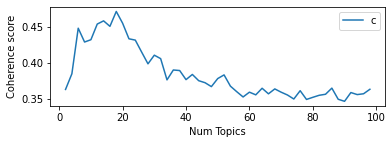

In [31]:
#Viewing coherence values
from matplotlib import pyplot as plt
limit=100; start=2; step=2;
x = range(start, limit, step)
plt.subplot(2,1,1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [32]:
# Print the coherence scores for each topic
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3632
Num Topics = 4  has Coherence Value of 0.385
Num Topics = 6  has Coherence Value of 0.4486
Num Topics = 8  has Coherence Value of 0.4293
Num Topics = 10  has Coherence Value of 0.4325
Num Topics = 12  has Coherence Value of 0.4544
Num Topics = 14  has Coherence Value of 0.4589
Num Topics = 16  has Coherence Value of 0.4512
Num Topics = 18  has Coherence Value of 0.472
Num Topics = 20  has Coherence Value of 0.4556
Num Topics = 22  has Coherence Value of 0.4338
Num Topics = 24  has Coherence Value of 0.432
Num Topics = 26  has Coherence Value of 0.4153
Num Topics = 28  has Coherence Value of 0.3989
Num Topics = 30  has Coherence Value of 0.411
Num Topics = 32  has Coherence Value of 0.4061
Num Topics = 34  has Coherence Value of 0.3765
Num Topics = 36  has Coherence Value of 0.3903
Num Topics = 38  has Coherence Value of 0.3895
Num Topics = 40  has Coherence Value of 0.3769
Num Topics = 42  has Coherence Value of 0.3841
Num Topics = 44  has 

## Selecting Optimal Model Based on Coherence Score


In [34]:
#Selecting optimal model based on coherence score
from pprint import pprint
optimal_model = model_list[9]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.048*"input" + 0.042*"output" + 0.032*"time" + 0.030*"differ" + '
  '0.027*"result" + 0.018*"step" + 0.017*"layer" + 0.017*"shape" + '
  '0.015*"charact" + 0.014*"length" + 0.014*"calcul" + 0.013*"sequenc" + '
  '0.012*"give" + 0.012*"oper" + 0.011*"score"'),
 (1,
  '0.036*"item" + 0.036*"button" + 0.032*"click" + 0.031*"api" + '
  '0.029*"window" + 0.019*"googl" + 0.018*"tkinter" + 0.015*"app" + '
  '0.013*"list" + 0.012*"url" + 0.011*"search" + 0.010*"consol" + 0.010*"issu" '
  '+ 0.009*"edit" + 0.008*"snippet"'),
 (2,
  '0.116*"imag" + 0.037*"plot" + 0.028*"opencv" + 0.022*"size" + '
  '0.020*"detect" + 0.019*"matplotlib" + 0.016*"color" + 0.013*"widget" + '
  '0.013*"background" + 0.012*"coordin" + 0.012*"point" + 0.012*"label" + '
  '0.012*"video" + 0.011*"pictur" + 0.011*"box"'),
 (3,
  '0.333*"file" + 0.126*"line" + 0.020*"command" + 0.013*"open" + 0.010*"csv" '
  '+ 0.008*"text" + 0.007*"output" + 0.006*"matlab" + 0.006*"larg" + '
  '0.006*"json" + 0.006*"activ" + 0.00

## Converting Mallet to Normal LDA Model


In [37]:
#Converting mallet to normal LDA model
from gensim.models.ldamodel import LdaModel
def convertldaGenToldaMallet(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha, eta=0,
    )
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

optimal_model = convertldaGenToldaMallet(optimal_model)

## Extracting Dominant Topic, Contribution, Keywords for Each Document


In [38]:
#Getting the dominant topic, contiribution, keywords for each document
def extract_topic_sentence(ldamodel=None, corpus=corpus, texts=data):
    sent_topics_df = pd.DataFrame()
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0: 
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = extract_topic_sentence(ldamodel=optimal_model, corpus=corpus, texts=data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'text']
print(len(df_dominant_topic))

16529


## Analyzing Popular and Challenging Topics

In [41]:
#Copying result to new dataframe
df_dominant_topic_copy = df_dominant_topic.copy()

In [43]:
#Merging back the df_subset based on text to analyse RQ5 popular and challenging topics
result=pd.merge(df_subset,df_dominant_topic_copy,on='text')

In [57]:
result=pd.merge(result,df,on=['Id','Body','Title'])
result.to_excel (r'E:\stackover_flow\Code\RQ5_result_2.xlsx', header=True)


## Getting Average Score, View, and Favorite Count

In [48]:
#Getting average_score, view and favorite count
import numpy as np
result=result.groupby(['Dominant_Topic'])
result_popularity=result.groupby(['Dominant_Topic']).agg({'ViewCount':np.sum,'Score':np.sum,'FavoriteCount':np.sum,'Id':len})
result_popularity=result_popularity.apply(lambda x: pd.Series(list(x[0:3]/x[-1])+[x[-1]]), axis=1)
result_popularity.columns=['AvgView','AvgScore','AvgFav','Count']
result_popularity

,AvgView,AvgScore,AvgFav,Count
Dominant_Topic,,,,
0.0,2356.113300,2.520525,0.863711,609.0
1.0,1908.889070,1.334421,0.368679,613.0
2.0,2253.111010,1.626024,0.501365,1099.0
3.0,1785.682213,1.085683,0.284165,922.0
4.0,1780.696246,1.527304,0.426621,1758.0
5.0,5707.434097,4.590258,1.113181,1396.0
6.0,1948.260000,2.058000,0.638000,500.0
7.0,2243.459135,2.110577,0.449519,416.0
8.0,3115.373272,2.859447,0.769585,434.0


## Determining Challenging Topics

In [49]:
#determing challenging topic
def anscountval(x):
    return (x>0).sum()
result_challenging=result.groupby(['Dominant_Topic']).agg({'AcceptedAnswerId':'count','AnswerCount':anscountval,'Id':len})
result_challenging

,AcceptedAnswerId,AnswerCount,Id
Dominant_Topic,,,
0.0,278,508,609
1.0,298,492,613
2.0,517,852,1099
3.0,445,772,922
4.0,1036,1545,1758
5.0,528,1076,1396
6.0,226,408,500
7.0,207,339,416
8.0,216,349,434


In [50]:
result_challenging=result_challenging.apply(lambda x: pd.Series([(x[-1]-x[0])/x[-1],(x[-1]-x[1])/x[-1],x[-1]]), axis=1)
result_challenging.columns=['PerDocWOAccAns','PerDocWOAns','Count']
result_challenging

,PerDocWOAccAns,PerDocWOAns,Count
Dominant_Topic,,,
0.0,0.543514,0.165846,609.0
1.0,0.513866,0.197390,613.0
2.0,0.529572,0.224750,1099.0
3.0,0.517354,0.162690,922.0
4.0,0.410694,0.121160,1758.0
5.0,0.621777,0.229226,1396.0
6.0,0.548000,0.184000,500.0
7.0,0.502404,0.185096,416.0
8.0,0.502304,0.195853,434.0


## Merging Popularity and Challenging Topic Results

In [55]:
#Getting results merged into one dataframe
result_final=pd.merge(result_popularity,result_challenging,on=['Dominant_Topic','Count'])
result_final

,AvgView,AvgScore,AvgFav,Count,PerDocWOAccAns,PerDocWOAns
Dominant_Topic,,,,,,
0.0,2356.113300,2.520525,0.863711,609.0,0.543514,0.165846
1.0,1908.889070,1.334421,0.368679,613.0,0.513866,0.197390
2.0,2253.111010,1.626024,0.501365,1099.0,0.529572,0.224750
3.0,1785.682213,1.085683,0.284165,922.0,0.517354,0.162690
4.0,1780.696246,1.527304,0.426621,1758.0,0.410694,0.121160
5.0,5707.434097,4.590258,1.113181,1396.0,0.621777,0.229226
6.0,1948.260000,2.058000,0.638000,500.0,0.548000,0.184000
7.0,2243.459135,2.110577,0.449519,416.0,0.502404,0.185096
8.0,3115.373272,2.859447,0.769585,434.0,0.502304,0.195853


In [53]:
#Extarcting to excel
result_final.to_excel (r'E:\stackover_flow\Code\RQ5_result_1.xlsx', header=True)


## Saving and Loading LDA Model

In [58]:
#Saving LDA model
optimal_model.save('lda.model')


In [151]:
#Loading the saved model
from gensim import corpora, models, similarities
model_loaded =  models.LdaModel.load('lda.model')


In [152]:
model_loaded.show_topics(formatted=False)

[(19,
  [('button', 0.031843886),
   ('displai', 0.018579142),
   ('click', 0.017558778),
   ('variabl', 0.016325837),
   ('tkinter', 0.012924621),
   ('gui', 0.012797075),
   ('url', 0.012244377),
   ('box', 0.011946771),
   ('imag', 0.010501254),
   ('figur', 0.010416224)]),
 (11,
  [('page', 0.033929467),
   ('html', 0.030962728),
   ('link', 0.027494568),
   ('search', 0.025656026),
   ('tag', 0.025071034),
   ('delet', 0.023148922),
   ('websit', 0.021770015),
   ('url', 0.019262912),
   ('scrape', 0.018761491),
   ('post', 0.01809293)]),
 (12,
  [('string', 0.0993669),
   ('list', 0.08561486),
   ('word', 0.03991447),
   ('match', 0.03232569),
   ('remov', 0.027378308),
   ('charact', 0.026707476),
   ('output', 0.019705672),
   ('split', 0.017148128),
   ('extract', 0.01685464),
   ('regex', 0.015764538)]),
 (3,
  [('list', 0.046920042),
   ('data', 0.041908734),
   ('json', 0.036320902),
   ('random', 0.017561754),
   ('load', 0.013836534),
   ('multipl', 0.012993924),
   ('rep

## Visualizing Topics with pyLDAvis

In [56]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(optimal_model, corpus, dictionary=optimal_model.id2word,mds='mmds')
vis


C:\Users\Hp\anaconda3\envs\LDA\lib\site-packages\pyLDAvis\_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.415027 -0.262817       1        1  5.333613
5     -0.472076  0.006016       2        1  5.313965
4      0.081224 -0.506663       3        1  5.282277
13    -0.235708 -0.353008       4        1  5.139633
18     0.081437  0.433468       5        1  5.130862
2     -0.202403  0.448897       6        1  5.118411
3     -0.381240  0.233497       7        1  5.078545
14    -0.000081 -0.104281       8        1  4.992765
0      0.332745 -0.252991       9        1  4.978559
15     0.349891 -0.088090      10        1  4.975263
1     -0.039618 -0.324860      11        1  4.909729
17     0.336273  0.218724      12        1  4.902309
16    -0.173745  0.165314      13        1  4.896826
6     -0.247975 -0.078916      14        1  4.885387
19    -0.039930  0.215412      15        1  4.879566
12     0.220135  0.287383      16        1  4.874267
8      0.133185 -0.225655      17        1  4.857522
7      0.218047  0.009970      18        1  4.838383
11     0.401218  0.081124      19        1  4.831848
9      0.053647  0.097476      20        1  4.780270, topic_info=        Term         Freq        Total Category  logprob  loglift
190     file  8967.000000  8967.000000  Default  30.0000  30.0000
37    column  3549.000000  3549.000000  Default  29.0000  29.0000
4       line  3255.000000  3255.000000  Default  28.0000  28.0000
209     imag  2940.000000  2940.000000  Default  27.0000  27.0000
11    django  2962.000000  2962.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
397   result   226.345068  2943.873410  Topic20  -4.6470   0.4753
216     show   130.872500   429.641981  Topic20  -5.1949   1.8519
80     print   156.617917  1767.587973  Topic20  -5.0153   0.6171
69       gui   128.727050   391.945507  Topic20  -5.2114   1.9272
198  specifi   128.727050   493.016664  Topic20  -5.2114   1.6978

[1767 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
688       5  0.967508  aattgnta
1731      1  1.072636    abbort
416      10  0.951318   abbrevi
3037      3  1.002624       abc
1496      8  0.992586  abstract
...     ...       ...       ...
768       7  0.837807       zip
768      10  0.059843       zip
768      14  0.085490       zip
768      20  0.017098       zip
6849     18  1.034567       zsh

[4504 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 6, 5, 14, 19, 3, 4, 15, 1, 16, 2, 18, 17, 7, 20, 13, 9, 8, 12, 10])

In [63]:
#Extarcting pyLDAVis as html
pyLDAvis.save_html(vis, 'lda.html')